<a href="https://colab.research.google.com/github/LSDtopotools/lsdtt_notebooks/blob/master/lsdtopotools/floodplain_and_terrace_examples/valley_width.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Valley width calculation using LSDTopoTools

*Written by Fiona J. Clubb, Durham University*

This notebook allows you to calculate river valley width from a DEM using LSDTopoTools. If you use this notebook, please cite the following paper:

Clubb, F. J., et al. (2022). Continuous measurements of valley floor width in mountainous landscapes. *Earth Surface Dynamics* 10(3): 437-456. https://doi.org/10.5194/esurf-10-437-2022

This notebook is designed to be run in Google Colab. If you want to run it locally, you will need to install LSDTopoTools onto your system. You can do this using conda.

To run this notebook you will need:
* A DEM of your area of interest in GeoTiff format

**We highly recommend that you save a copy of this notebook in your Google Drive before you start, so that you save any changes that you make as you go. To do that you can just click the button "Copy to Drive" in the menu bar near the top of the page.**

-----------
Changelog:

15/03/2024: notebook created, FJC

29/04/2024: added some more parameters for valley width extraction to include absolute thresholds, FJC

-----------

## Install required packages

The first step is to install and import the packages we need to run the notebook using the code blocks below:

In [ ]:
!pip install rasterio &> /dev/null

In [ ]:
# import packages
import _pickle as pickle
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import matplotlib.pyplot as plt

### Install LSDTopoTools
The next step is to install `lsdtopotools`. The first line downloads the package and the second installs it. The `/dev/null` stuff is just to stop the notebook printing text to screen.

In [ ]:
!wget https://pkgs.geos.ed.ac.uk/geos-jammy/pool/world/l/lsdtopotools2/lsdtopotools2_0.9-1geos~22.04.1_amd64.deb  &> /dev/null
!apt install ./lsdtopotools2_0.9-1geos~22.04.1_amd64.deb  &> /dev/null

Now let's test whether we installed LSDTopoTools succesfully. If you get some output asking for a parameter file then `lsdtopotools` is installed. This notebook was tested on version 0.9.

In [ ]:
!lsdtt-basic-metrics -v

|| Welcome to the LSDTopoTools basic metrics tool!     ||
|| This program has a number of options for calculating||
|| simple landscape metrics.                           ||
|| This program was developed by Simon M. Mudd         ||
||  at the University of Edinburgh                     ||
|| If you use these routines please cite:              ||
|| http://doi.org/10.5281/zenodo.4577879               ||
|| If you use the roughness routine please cite:       ||
|| https://www.doi.org/10.5194/esurf-3-483-2015        ||
|| Documentation can be found at:                      ||
|| https://lsdtopotools.github.io/LSDTT_documentation/ ||
|| This is LSDTopoTools2 version                       ||
|| 0.9
|| If the version number has a d at the end it is a    ||
||  development version.                               ||
|| You have called an LSDTopoTools program.            ||
|| Prepare to explore topographic data!                ||
|| You can find some examples of usage here:           ||
|| http

We also need the gdal tools to convert your DEM to a format suitable for LSDTopoTools:

In [ ]:
!apt install gdal-bin  &> /dev/null

## Upload your DEM to Google Colab

The next step is to upload your DEM for your area of interest to Google Colab. To do this, click on the small folder icon on the left hand bar and then click `Upload to Session Storage`.

Make sure you wait until the DEM is fully uploaded before running the cell below, or you will get an error!

Your DEM should be in GeoTiff format and **needs to be in a UTM WGS84 coordinate system.**

LSDTopoTools requires data in a slightly different format (ENVI bil). The following line uses gdal to convert your DEM into the ENVI bil format.

--------

**NOTE: Make sure you modify the variables "DEM_name" and "res" below to match the name of your GeoTiff file and the resolution of your DEM. In my example, I have uploaded a DEM called "Hokitika_15m.tif" which has a 15 m grid resolution.**

________

In [ ]:
DEM_name = 'Hokitika_15m'       # name of your DEM without the .tif extension
res = 15                        # Your DEM resolution

!gdalwarp -of ENVI -r cubic -dstnodata -9999 -tr {res} {res} {DEM_name}.tif {DEM_name}.bil

Creating output file that is 1990P x 2448L.
Processing Hokitika_15m.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image Hokitika_15m.tif.
Copying nodata values from source Hokitika_15m.tif to destination Hokitika_15m.bil.
...10...20...30...40...50...60...70...80...90...100 - done.


## Run the valley width code

Now we can go ahead and run the valley width analysis! LSDTopoTools is run through the command line. You can decide what analyses you want LSDTopoTools to do by giving it a parameter file - you just need to set the various options in the parameter file accordingly.

We can create a parameter file in Python by creating a dictionary with the parameters and values, and then writing this to a text file which will be read by LSDTopoTools.

In [ ]:
# create the parameter dictionary
param_dict = {
    'read fname': DEM_name,                        # the name of your DEM (declared above)
    'write fname': DEM_name,                       # code will write some other rasters - they will have a prefix matching your DEM name
    'write_hillshade': 'true',                     # set to true if you want to print a hillshade of the DEM
    'remove_seas': 'true',                         # replace elevations <=0 with nodata
    'threshold_contributing_pixels': 1000,         # drainage area threshold for channel extraction (in number of pixels)
    'surface_fitting_radius': 30,                  # window radius used for calculating slope (in metres). Needs reducing for high-resolution DEMs
    'use_absolute_thresholds': 'false',            # set this to true if you want to override the quantile-quantile approach for identifying the valley floor thresholds and instead set user-defined slope and relief thresholds
    'relief_threshold': 50,                        # when use_absolute_thresholds is true this is the channel relief threshold below which you get a valley floor
    'slope_threshold': 0.1,                        # when use_absolute_thresholds is true this is the slope threshold below which you get a valley floor
    'fill_floodplain': 'true',                     # fill small holes in the floodplain using the OpenCV FloodFill algorithm
    'extract_all_channels': 'true',                # set this to true if you want valley width for all channels in the DEM
    'extract_longest_channel': 'false',            # set this to true if you want valley width for only the longest channel in the DEM
    'get_valley_widths': 'true',                   # keep true to run valley width calculation
    'width_node_spacing': 20,                      # spacing between channel nodes used to calculate flow direction for valley widths. A larger value will result in less variable width measurement directions
    'valley_banks_search_radius': 100              # a half width used to search for the edges of the valley for width calculation. Large values increase computational cost.
    }

In [ ]:
# write it to a text file
strings = [ f'{key}: {param_dict[key]}' for key in param_dict]
with open('LSDTT_valleys.param', 'w') as file:
  [file.write(f'{st}\n') for st in strings]

Now we have our parameter file, we can run the valley width analysis:

In [ ]:
!lsdtt-valley-metrics LSDTT_valleys.param

|| Welcome to the LSDTopoTools valley metrics tool!    ||
|| This program extracts floodplains and               ||
|| terraces using slope and relief_thresholds.         ||
|| This program was developed by                       ||
|| Fiona J. Clubb, Durham University, and              ||
|| Simon M Mudd at the University of Edinburgh         ||
|| Citation for this code is:                          ||
|| http://doi.org/10.5281/zenodo.4577879
|| And                                                 ||
|| https://doi.org/10.5194/esurf-5-369-2017            ||
|| https://doi.org/10.5194/esurf-10-437-2022           ||
|| Documentation can be found at:                      ||
|| https://lsdtopotools.github.io/LSDTT_documentation/ ||
|| This is LSDTopoTools2 version                       ||
|| 0.9
|| If the version number has a d at the end it is a    ||
||  development version.                               ||
|| You have called an LSDTopoTools program.            ||
|| Prepare to explore to

We have now run our valley width analysis! If you look in the files list, you should see many new files have been produced. You can download these and load them into a GIS, or you can look at them directly in Python in the following code blocks.

## Visualising the valley width results

The main outputs of the valley width code are:

1. A raster showing the calculated valley floor (DEM_name_valley.bil)
2. A GeoJSON file with the valley width measurements (DEM_name_valley_width_network_orthogonal.geojson).

The code block below the valley width measurements into Python using the `Geopandas` package and drapes them onto a hillshade, which is loaded using the `rasterio` package.

In [ ]:
# read in the hillshaded DEM
src = rio.open(DEM_name+'_hs.bil')
crs = src.crs

# read in the valley width data and convert to the same coordinate system as the DEM (UTM WGS84)
vw = gpd.read_file(DEM_name+'_valley_width_network_orthogonal.geojson').to_crs(crs)

In [ ]:
print(vw.crs)

PROJCS["WGS 84 / UTM zone 59S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32759"]]


<Axes: >

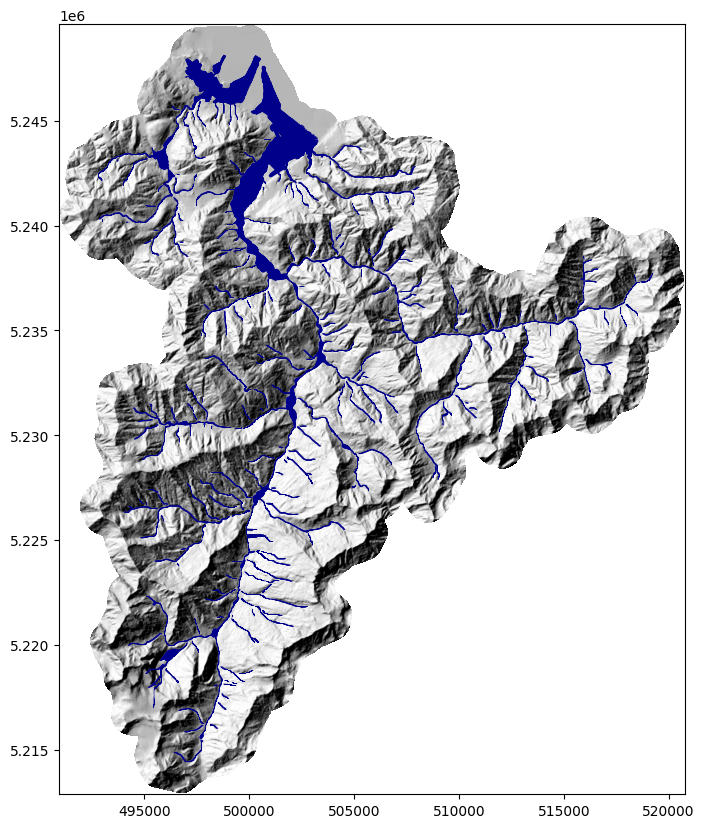

In [ ]:
# set up the figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))

# plot the hillshade
hs = src.read(1, masked=True)
plt.imshow(hs, cmap='gray', extent=plotting_extent(src))

# plot the valley width data
vw.plot(ax=ax, edgecolors='darkblue')

## Analysing the valley width results

The GeoJSON file with the valley width data contains a lot of information about each valley width measurement. To see what it contains, you can have a look at the GeoDataFrame:

In [ ]:
vw

,total_valley_width,source_id,distance_from_outlet,drainage_area,elevation,left_valley_width,right_valley_width,centreline_node,centreline_latitude,centreline_longitude,flow_bearing,orthogonal_bearing,geometry
0,1912.148930,34571,3656.90845,324000,120.295624,512.640198,1399.50879,30300,-42.929004,170.963128,70.252739,160.252747,"LINESTRING (496811.174 5247548.499, 497456.135..."
1,1978.012700,34571,3635.69531,324225,118.203835,569.209961,1408.80273,29954,-42.928869,170.963312,71.662819,161.662811,"LINESTRING (496826.155 5247623.496, 497456.135..."
2,2068.954590,34571,3614.48218,324450,115.729774,640.800293,1428.15442,29610,-42.928734,170.963496,73.086914,163.086914,"LINESTRING (496841.129 5247713.496, 497441.129..."
3,1743.239140,34571,3593.26904,324675,113.439262,702.602295,1040.63684,29267,-42.928599,170.963680,74.518127,164.518127,"LINESTRING (496841.177 5247788.497, 497306.119..."
4,1859.114380,34571,3578.26904,324900,111.862579,822.268188,1036.84619,29268,-42.928599,170.963863,75.594605,165.594604,"LINESTRING (496841.121 5247908.505, 497306.119..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20937,570.881592,67831,1738.05127,569700,53.000149,510.881592,60.00000,51749,-42.936439,171.009267,175.734619,265.734619,"LINESTRING (501266.155 5246273.505, 500696.146..."
20938,557.041260,67831,1723.05127,569925,53.000000,497.041260,60.00000,51339,-42.936304,171.009267,174.345016,264.345032,"LINESTRING (501251.148 5246303.501, 500696.147..."
20939,542.104736,67831,1708.05127,570150,52.999676,482.104767,60.00000,50930,-42.936169,171.009267,174.345016,264.345032,"LINESTRING (501236.137 5246318.495, 500696.149..."
20940,527.172363,67831,1693.05127,570375,52.995823,467.172333,60.00000,50522,-42.936033,171.009267,174.345016,264.345032,"LINESTRING (501221.127 5246333.500, 500696.150..."


The columns should be fairly self explanatory: you should see we have information about the total valley width, drainage area, elevation, and distance from the outlet for each measurement. This allows us to plot how valley width varies with distance downstream as well as with drainage area. You can also plot the river long profiles with the same information.

The `source_id` tells you which channel the measurements come from - we have measurements from every channel in the DEM. You can group the measurements by source ID to analyse each channel individually.

### Example: valley width vs. drainage area

In this example, I first of all filter the GeoJSON to only take the main stem of the catchment by looking for the source ID with the farthest distance from the outlet.

I then make a logarithmic plot of valley width against drainage area.

In [ ]:
# filter the GeoJSON by source ID
gr = vw.groupby('source_id')['distance_from_outlet'].count().reset_index()
main_stem_ID = gr['source_id'][gr['distance_from_outlet'].idxmax()]
main_stem_vw = vw[vw.source_id == main_stem_ID]

Text(0, 0.5, 'Valley width (m)')

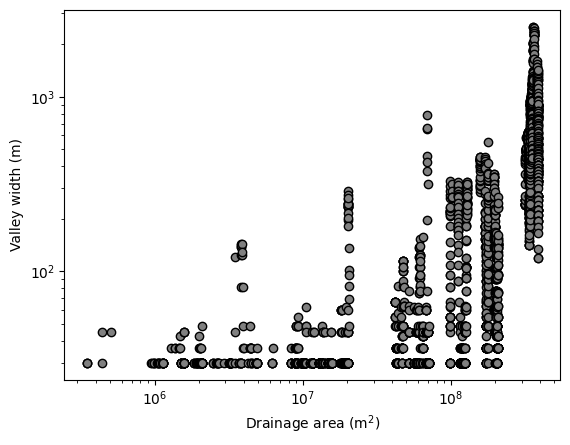

In [ ]:
# plot valley width vs drainage area for the main stem
plt.scatter(main_stem_vw.drainage_area, main_stem_vw.total_valley_width, c='grey', edgecolors='black')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Drainage area (m$^2$)')
plt.ylabel('Valley width (m)')